Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from matplotlib import pyplot as plt
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
batch_size = 256
hidden_layer_size = 1024
learning_rate = 0.5
l2_regularization_penalty = 0.001

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(dtype=tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(dtype=tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # First hidden layer
    with tf.name_scope("hidden1"):
        weights = tf.Variable(tf.truncated_normal((image_size * image_size, hidden_layer_size)))
        biases = tf.Variable(tf.zeros(hidden_layer_size))
        hidden_layer_dict = {"weights": weights, "biases": biases}
        
    # Logits layer
    with tf.name_scope("logits"):
        weights = tf.Variable(tf.truncated_normal((hidden_layer_size, num_labels)))
        biases = tf.Variable(tf.zeros(num_labels))
        logits_layer_dict = {"weights": weights, "biases": biases}
        
    def forward_prop(X):
        hidden_activation = tf.nn.relu(tf.matmul(X, hidden_layer_dict["weights"]) + hidden_layer_dict["biases"])
        logits_output = tf.matmul(hidden_activation, logits_layer_dict["weights"]) + logits_layer_dict["biases"]
        return logits_output
        
    unregularized_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(forward_prop(tf_train_dataset), tf_train_labels))
    
    l2_loss = l2_regularization_penalty * (tf.nn.l2_loss(hidden_layer_dict["weights"]) + tf.nn.l2_loss(logits_layer_dict["weights"]))
    
    loss = unregularized_loss + l2_loss
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    #predictions
    train_prediction = tf.nn.softmax(forward_prop(tf_train_dataset))
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Completed 0 steps
Completed 10000 steps
Completed 20000 steps
Completed 30000 steps
Completed 40000 steps
Completed 50000 steps
Completed 60000 steps
Completed 70000 steps
Completed 80000 steps
Completed 90000 steps
Test Accuracy: 95.0


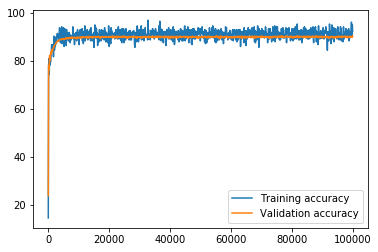

In [6]:
steps = 100000
losses = []
acc = []
valid_acc = []
graph_step = 100
print_step = 10000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        if (step % graph_step == 0):
            losses.append(l)
            acc.append(accuracy(predictions, batch_labels))
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
        
        if (step % print_step == 0):
            print("Completed {} steps".format(step))
    
    print("Test Accuracy: {}".format(accuracy(test_prediction.eval(), test_labels)))

plt.plot(range(0, steps, graph_step), acc)
plt.plot(range(0, steps, graph_step), valid_acc)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Completed 0 steps
Completed 10000 steps
Test Accuracy: 89.01


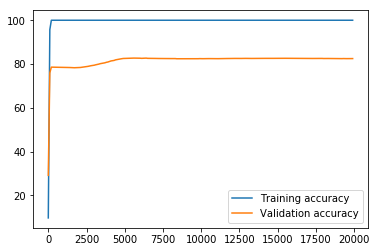

In [7]:
# Uses same graph as Problem 1

steps = 20000
losses = []
acc = []
valid_acc = []
graph_step = 100
print_step = 10000

restrict_to_batches = 10

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(steps):
        offset = ((step % restrict_to_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        if (step % graph_step == 0):
            losses.append(l)
            acc.append(accuracy(predictions, batch_labels))
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
        
        if (step % print_step == 0):
            print("Completed {} steps".format(step))
    
    print("Test Accuracy: {}".format(accuracy(test_prediction.eval(), test_labels)))

plt.plot(range(0, steps, graph_step), acc)
plt.plot(range(0, steps, graph_step), valid_acc)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [8]:
batch_size = 256
hidden_layer_size = 1024
learning_rate = 0.5
l2_regularization_penalty = 0.001

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(dtype=tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(dtype=tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # First hidden layer
    with tf.name_scope("hidden1"):
        weights = tf.Variable(tf.truncated_normal((image_size * image_size, hidden_layer_size)))
        biases = tf.Variable(tf.zeros(hidden_layer_size))
        hidden_layer_dict = {"weights": weights, "biases": biases}
        
    # Logits layer
    with tf.name_scope("logits"):
        weights = tf.Variable(tf.truncated_normal((hidden_layer_size, num_labels)))
        biases = tf.Variable(tf.zeros(num_labels))
        logits_layer_dict = {"weights": weights, "biases": biases}
        
    def forward_prop(X):
        hidden_activation = tf.nn.relu(tf.matmul(X, hidden_layer_dict["weights"]) + hidden_layer_dict["biases"])
        logits_output = tf.matmul(hidden_activation, logits_layer_dict["weights"]) + logits_layer_dict["biases"]
        return tf.nn.dropout(logits_output, 0.4)
    
    def forward_prop_no_dropout(X):
        hidden_activation = tf.nn.relu(tf.matmul(X, hidden_layer_dict["weights"]) + hidden_layer_dict["biases"])
        logits_output = tf.matmul(hidden_activation, logits_layer_dict["weights"]) + logits_layer_dict["biases"]
        return logits_output
        
    unregularized_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(forward_prop(tf_train_dataset), tf_train_labels))
    
    l2_loss = l2_regularization_penalty * (tf.nn.l2_loss(hidden_layer_dict["weights"]) + tf.nn.l2_loss(logits_layer_dict["weights"]))
    
    loss = unregularized_loss + l2_loss
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    #predictions
    train_prediction = tf.nn.softmax(forward_prop_no_dropout(tf_train_dataset))
    valid_prediction = tf.nn.softmax(forward_prop_no_dropout(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop_no_dropout(tf_test_dataset))

Completed 0 steps
Completed 10000 steps
Completed 20000 steps
Completed 30000 steps
Completed 40000 steps
Completed 50000 steps
Completed 60000 steps
Completed 70000 steps
Completed 80000 steps
Completed 90000 steps
Test Accuracy: 93.93


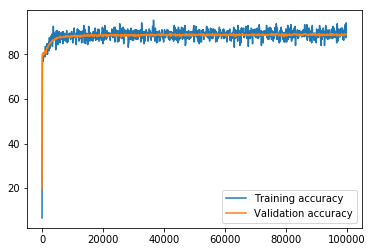

In [9]:
steps = 100000
losses = []
acc = []
valid_acc = []
graph_step = 100
print_step = 10000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        if (step % graph_step == 0):
            losses.append(l)
            acc.append(accuracy(predictions, batch_labels))
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
        
        if (step % print_step == 0):
            print("Completed {} steps".format(step))
    
    print("Test Accuracy: {}".format(accuracy(test_prediction.eval(), test_labels)))

plt.plot(range(0, steps, graph_step), acc)
plt.plot(range(0, steps, graph_step), valid_acc)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

Testing over-fitting scenario

Completed 0 steps
Completed 10000 steps
Test Accuracy: 91.72


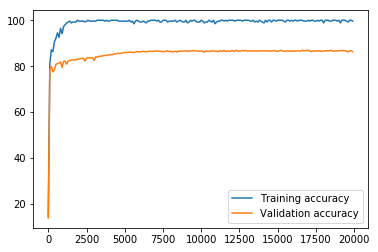

In [10]:
# Uses same graph

steps = 20000
losses = []
acc = []
valid_acc = []
graph_step = 100
print_step = 10000

restrict_to_batches = 50

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(steps):
        offset = ((step % restrict_to_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        if (step % graph_step == 0):
            losses.append(l)
            acc.append(accuracy(predictions, batch_labels))
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
        
        if (step % print_step == 0):
            print("Completed {} steps".format(step))
    
    print("Test Accuracy: {}".format(accuracy(test_prediction.eval(), test_labels)))

plt.plot(range(0, steps, graph_step), acc)
plt.plot(range(0, steps, graph_step), valid_acc)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Completed 0 steps
Completed 10000 steps
Completed 20000 steps
Completed 30000 steps
Completed 40000 steps
Completed 50000 steps
Completed 60000 steps
Completed 70000 steps
Completed 80000 steps
Completed 90000 steps
Test Accuracy: 94.27


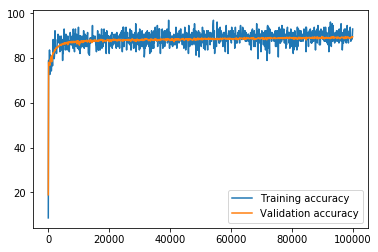

In [11]:
batch_size = 128
hidden_layer_size = 1024
learning_rate = 0.5
l2_regularization_penalty = 0.001

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(dtype=tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(dtype=tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # First hidden layer
    with tf.name_scope("hidden1"):
        weights = tf.Variable(tf.truncated_normal((image_size * image_size, hidden_layer_size)))
        biases = tf.Variable(tf.zeros(hidden_layer_size))
        hidden_layer_dict = {"weights": weights, "biases": biases}
        
    # Logits layer
    with tf.name_scope("logits"):
        weights = tf.Variable(tf.truncated_normal((hidden_layer_size, num_labels)))
        biases = tf.Variable(tf.zeros(num_labels))
        logits_layer_dict = {"weights": weights, "biases": biases}
        
    def forward_prop(X):
        hidden_activation = tf.nn.relu(tf.matmul(X, hidden_layer_dict["weights"]) + hidden_layer_dict["biases"])
        logits_output = tf.matmul(hidden_activation, logits_layer_dict["weights"]) + logits_layer_dict["biases"]
        return tf.nn.dropout(logits_output, 0.5)
    
    def forward_prop_no_dropout(X):
        hidden_activation = tf.nn.relu(tf.matmul(X, hidden_layer_dict["weights"]) + hidden_layer_dict["biases"])
        logits_output = tf.matmul(hidden_activation, logits_layer_dict["weights"]) + logits_layer_dict["biases"]
        return logits_output
        
    unregularized_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(forward_prop(tf_train_dataset), tf_train_labels))
    
    l2_loss = l2_regularization_penalty * (tf.nn.l2_loss(hidden_layer_dict["weights"]) + tf.nn.l2_loss(logits_layer_dict["weights"]))
    
    loss = unregularized_loss + l2_loss
    
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate, global_step,
                                           5000, 0.96)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    #predictions
    train_prediction = tf.nn.softmax(forward_prop_no_dropout(tf_train_dataset))
    valid_prediction = tf.nn.softmax(forward_prop_no_dropout(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop_no_dropout(tf_test_dataset))
    
steps = 100000
losses = []
acc = []
valid_acc = []
graph_step = 100
print_step = 10000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        if (step % graph_step == 0):
            losses.append(l)
            acc.append(accuracy(predictions, batch_labels))
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
        
        if (step % print_step == 0):
            print("Completed {} steps".format(step))
    
    print("Test Accuracy: {}".format(accuracy(test_prediction.eval(), test_labels)))

plt.plot(range(0, steps, graph_step), acc)
plt.plot(range(0, steps, graph_step), valid_acc)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()